In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from collections import OrderedDict


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

def get_params_per_layer(model):
    params_list = []
    for name, param in model.named_parameters():
        params_list.append(param.data.view(-1))
    return params_list

def get_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])

def set_params(model, params):
    param_shapes = [param.data.shape for param in model.parameters()]
    param_sizes = [param.numel() for param in model.parameters()]

    index = 0
    for i, param in enumerate(model.parameters()):
        size = param_sizes[i]
        param_slice = params[index:index + size].view(param_shapes[i])
        param.data.copy_(param_slice)
        index += size

def set_params_per_layer(model, params_list):
    index = 0
    for name, param in model.named_parameters():
        original_shape = param.data.shape
        param.data.copy_(params_list[index].view(original_shape))
        index += 1


def split(train_dataset, alpha, num_clients):
    train_size = len(train_dataset)
    subsets = [[] for _ in range(10)]
    final_dataset = [[] for _ in range(num_clients)]
    final_size = train_size // num_clients
    for i in range(train_size):
        image, label = train_dataset[i]
        subsets[label].append((image, label))

    w0 = torch.tensor([1/10 for _ in range(10)])
    dir = dist.Dirichlet(w0*alpha)
    for i in range(num_clients):
        w = dir.sample()
        samples = torch.multinomial(w, final_size, replacement=True)
        for j in range(final_size):
            a = torch.randint(0, len(subsets[samples[j]]), (1,)).item()
            final_dataset[i].append(subsets[samples[j]][a])


    datasets_tensor = []
    for i in range(num_clients):
        images = torch.stack([x[0] for x in final_dataset[i]])
        labels = torch.tensor([x[1] for x in final_dataset[i]], dtype=torch.int64)
        datasets_tensor.append(TensorDataset(images, labels))


    return datasets_tensor


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_dataset = DataLoader(test_dataset, batch_size=64, shuffle=False)

def client_train(model, train_loader, optimizer, criterion, epochs=1, noise_std=0.01):
    model.train()
    for _ in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            for param in model.parameters():
                noise = torch.randn_like(param.data) * noise_std
                param.data.add_(noise)

    

num_clients = 5 
T = 40
num_epochs = 2
theta = 0.5
gamma = 0.1 
noise_std = 0.01
alpha = 0.1

train_datasets = split(train_dataset, alpha, num_clients)


batch_size = 128
learning_rate = 0.01 




In [ ]:
def fedavg(gamma):
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

    global_model = MLP()
    criterion = nn.CrossEntropyLoss()
    client_models = [MLP() for _ in range(num_clients)]
    client_optimizers = [optim.SGD(model.parameters(), lr=f) for model in client_models]

    client_data_sizes = [len(loader.dataset) for loader in client_loaders]

    params1 = get_params(global_model)
    mm = [torch.zeros_like(params1) for _ in range(num_clients)]
    print(params1.shape)

    accuracy = []
    for t in range(T):
        print(t)
        if(t%5==0):
            gamma = gamma/2
        for i, client_loader in enumerate(client_loaders):
            params1 = get_params(client_models[i])
            client_train(client_models[i], client_loader, client_optimizers[i], criterion, epochs=num_epochs, noise_std=noise_std)
            params2 = get_params(client_models[i])
            mm[i] = theta*mm[i]+(1-theta)*(params1-params2)/(learning_rate * num_epochs)

        global_params = get_params(global_model)
        sum_tensor = torch.stack([mm[i] for i in range(num_clients)], 0).sum(0)
        global_params -= gamma * sum_tensor/num_clients

        set_params(global_model,global_params)
        for i, client_model in enumerate(client_models):
            set_params(client_model,global_params)

        if (t + 1) % 2 == 0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_dataset:
                    images, labels = data
                    outputs = global_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                accuracy.append(100 * correct / total)

            print('Step {}: loss = {}, Accuracy of the network on the 10000 test images: {} %'.format(t + 1, loss, 100 * correct / total)) 

    return accuracy


In [ ]:
def normed_fedavg(gamma):
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

    global_model = MLP()
    criterion = nn.CrossEntropyLoss()
    client_models = [MLP() for _ in range(num_clients)]
    client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

    client_data_sizes = [len(loader.dataset) for loader in client_loaders]

    params1 = get_params(global_model)
    mm = [torch.zeros_like(params1) for _ in range(num_clients)]
    print(params1.shape)

    accuracy = []
    for t in range(T):
        print(t)
        if(t%5==0):
            gamma = gamma/2
        for i, client_loader in enumerate(client_loaders):
            params1 = get_params(client_models[i])
            client_train(client_models[i], client_loader, client_optimizers[i], criterion, epochs=num_epochs, noise_std=noise_std)
            params2 = get_params(client_models[i])
            mm[i] = theta*mm[i]+(1-theta)*(params1-params2)/(learning_rate * num_epochs)

        global_params = get_params(global_model)
        sum_tensor = torch.stack([mm[i] for i in range(num_clients)], 0).sum(0)
        global_params -= gamma * sum_tensor/torch.norm(sum_tensor, p = 2)

        set_params(global_model,global_params)
        for i, client_model in enumerate(client_models):
            set_params(client_model,global_params)

        if (t + 1) % 2 == 0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_dataset:
                    images, labels = data
                    outputs = global_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                accuracy.append(100 * correct / total)

            print('Step {}: loss = {}, Accuracy of the network on the 10000 test images: {} %'.format(t + 1, loss, 100 * correct / total)) 

    return accuracy


In [ ]:
gamma = 500
accuracy_fedavg = fedavg(gamma)
accuracy_normed_fedavg = normed_fedavg(gamma)
gammas = [200,100,50,20,10,5,2,1,0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001]
for gamma in gammas:
    print(gamma)
    accuracy_fedavg_new = fedavg(gamma)
    accuracy_normed_fedavg_new = normed_fedavg(gamma)
    if accuracy_fedavg_new[-1] >= accuracy_fedavg[-1]:
        accuracy_fedavg = accuracy_fedavg_new
    if accuracy_normed_fedavg_new[-1] >= accuracy_normed_fedavg[-1]:
        accuracy_normed_fedavg = accuracy_normed_fedavg_new

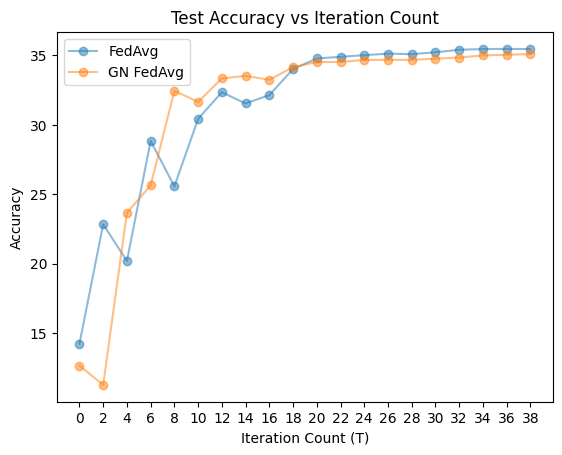

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

T = np.arange(0, 40, 2)

plt.plot(T, accuracy_fedavg, '-o', label='FedAvg', alpha=0.5)
plt.plot(T, accuracy_normed_fedavg, '-o', label='GN FedAvg', alpha=0.5)

plt.xticks(T)

plt.title('Test Accuracy vs Iteration Count')
plt.xlabel('Iteration Count (T)')
plt.ylabel('Accuracy')

plt.legend()

plt.show()